In [217]:
import pandas as pd
import pyarrow.parquet as pq
import datetime
import numpy as np
import matplotlib.pyplot as plt


## Get some data to experiment

I extract one series from the train set, i need later to change the code to go series by series, otherwise mistakes will occure.

In [218]:
file_path = '/Users/ra/Library/CloudStorage/OneDrive-HochschuleLuzern/AICH/data/Prepared/V2/train_20231021'

table = pq.read_table(file_path)

# Convert the table to a Pandas DataFrame
df = table.to_pandas()

In [219]:
series_list =df.series_id.unique().tolist()

Keep only a part of the series for testing

In [220]:
sample = df[df['series_id'].isin(series_list[0:10])]
sample.head()

,step,anglez,enmo,hour,minute,seconds,day,month,year,seconds_from_midnight,awake,wearable_on,series_id,onset,wakeup
25764840,0,-89.497597,0.0182,11,0,0,6,8,2018,39600,1.0,0.0,2fc653ca75c7,0,0
25764841,1,-89.497398,0.0182,11,0,5,6,8,2018,39605,1.0,0.0,2fc653ca75c7,0,0
25764842,2,-89.495598,0.0180,11,0,10,6,8,2018,39610,1.0,0.0,2fc653ca75c7,0,0
25764843,3,-89.496498,0.0183,11,0,15,6,8,2018,39615,1.0,0.0,2fc653ca75c7,0,0
25764844,4,-89.497597,0.0178,11,0,20,6,8,2018,39620,1.0,0.0,2fc653ca75c7,0,0


## Restore Timestamp

I have to recreat the timestamp, maybe we fix this an keep the timestamp for the future or so?

In [221]:
sample.loc[:, 'hour'] = sample['hour'].astype(str).str.zfill(2)
sample.loc[:, 'minute'] = sample['minute'].astype(str).str.zfill(2)
sample.loc[:, 'seconds'] = sample['seconds'].astype(str).str.zfill(2)
sample.loc[:, 'day'] = sample['day'].astype(str).str.zfill(2)
sample.loc[:, 'month'] = sample['month'].astype(str).str.zfill(2)
sample.loc[:, 'year'] = sample['year'].astype(str)

# Combine the columns into a new column 'timestamp'
sample['timestamp'] = sample['year'] + '-' + sample['month'] + '-' + sample['day'] + ' ' + sample['hour'] + ':' + sample['minute'] + ':' + sample['seconds']

# Convert 'timestamp' to datetime format
sample['timestamp'] = pd.to_datetime(sample['timestamp'])


/var/folders/40/3xwnc19j5wddty6wnqjyxg1h0000gn/T/ipykernel_14004/334975676.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['timestamp'] = sample['year'] + '-' + sample['month'] + '-' + sample['day'] + ' ' + sample['hour'] + ':' + sample['minute'] + ':' + sample['seconds']
/var/folders/40/3xwnc19j5wddty6wnqjyxg1h0000gn/T/ipykernel_14004/334975676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['timestamp'] = pd.to_datetime(sample['timestamp'])


In [222]:
sample.head()

,step,anglez,enmo,hour,minute,seconds,day,month,year,seconds_from_midnight,awake,wearable_on,series_id,onset,wakeup,timestamp
25764840,0,-89.497597,0.0182,11,00,00,06,08,2018,39600,1.0,0.0,2fc653ca75c7,0,0,2018-08-06 11:00:00
25764841,1,-89.497398,0.0182,11,00,05,06,08,2018,39605,1.0,0.0,2fc653ca75c7,0,0,2018-08-06 11:00:05
25764842,2,-89.495598,0.0180,11,00,10,06,08,2018,39610,1.0,0.0,2fc653ca75c7,0,0,2018-08-06 11:00:10
25764843,3,-89.496498,0.0183,11,00,15,06,08,2018,39615,1.0,0.0,2fc653ca75c7,0,0,2018-08-06 11:00:15
25764844,4,-89.497597,0.0178,11,00,20,06,08,2018,39620,1.0,0.0,2fc653ca75c7,0,0,2018-08-06 11:00:20


## just keep necessary columns

i only keep necessary columns for the moment

In [223]:
#sample = sample.reset_index()
sample = sample[['step', 'awake', 'wearable_on', 'series_id', 'timestamp']]
sample.head(3)

,step,awake,wearable_on,series_id,timestamp
25764840,0,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:00
25764841,1,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:05
25764842,2,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:10


In [224]:
sample.awake.unique()

array([1., 0.])

In [225]:
sample.wearable_on.unique()

array([0., 1.])

## Add some noise to the data

TO DO: For the moment i need to add artifical noise to awake and wearable on

In [226]:
# Define the probability of a value flip (0 to 1 or 1 to 0) fo awake
flip_probability = 0.25  

# Generate random noise
noise = np.random.rand(len(sample)) < flip_probability

# Apply noise to the 'awake' column
sample['awake'] = (sample['awake'] + noise) % 2

# Define the probability of a value flip (0 to 1 or 1 to 0) for wearable
flip_probability = 0.15

# Generate random noise
noise = np.random.rand(len(sample)) < flip_probability

# Apply noise to the 'awake' column
sample['wearable_on'] = (sample['wearable_on'] + noise) % 2



In [227]:
sample.head(20)

,step,awake,wearable_on,series_id,timestamp
25764840,0,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:00
25764841,1,0.0,0.0,2fc653ca75c7,2018-08-06 11:00:05
25764842,2,0.0,0.0,2fc653ca75c7,2018-08-06 11:00:10
25764843,3,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:15
25764844,4,1.0,1.0,2fc653ca75c7,2018-08-06 11:00:20
25764845,5,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:25
25764846,6,1.0,1.0,2fc653ca75c7,2018-08-06 11:00:30
25764847,7,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:35
25764848,8,1.0,0.0,2fc653ca75c7,2018-08-06 11:00:40
25764849,9,0.0,0.0,2fc653ca75c7,2018-08-06 11:00:45


## What happens with removed device timesteps...?

TO DO: restore the lost information of device removed
For the moment i work if i already had done this

## Encode wearable not on

For device not worn i give number 3 to awake, maybe i need smarter solution later on.

In [228]:
sample.loc[sample['wearable_on'] == 0.0, 'awake'] = 3

In [229]:
sample.awake.unique()

array([3., 1., 0.])

In [230]:
sample.head()

,step,awake,wearable_on,series_id,timestamp
25764840,0,3.0,0.0,2fc653ca75c7,2018-08-06 11:00:00
25764841,1,3.0,0.0,2fc653ca75c7,2018-08-06 11:00:05
25764842,2,3.0,0.0,2fc653ca75c7,2018-08-06 11:00:10
25764843,3,3.0,0.0,2fc653ca75c7,2018-08-06 11:00:15
25764844,4,1.0,1.0,2fc653ca75c7,2018-08-06 11:00:20


## Step 1 binning the data on 1 min

This i have to do for each series

In [232]:
sample['timestamp'] = pd.to_datetime(sample['timestamp'])


In [233]:
# Step 1: Split the DataFrame by 'series_id'
separated_dfs = [group for _, group in sample.groupby('series_id')]

# Step 2: Apply binning to each separate DataFrame
custom_agg_function = lambda x: x.value_counts().idxmax()
bin_size = '1Min'

binned_dfs = []

for df_subset in separated_dfs:
    
    binned_df = df_subset.resample(bin_size, on='timestamp').agg({
        'series_id': 'first',
        'step': 'first',
        'awake': custom_agg_function,
        'wearable_on': custom_agg_function
    }).reset_index()
    
    binned_dfs.append(binned_df)

# Step 3: Concatenate the DataFrames back together
result = pd.concat(binned_dfs)
result.reset_index(drop=True, inplace=True)


In [234]:

result.head()


,timestamp,series_id,step,awake,wearable_on
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0


In [235]:
# sanity check
result[result.step.isna()]

,timestamp,series_id,step,awake,wearable_on


## find the changes

In [236]:
# Find the occurrences of changes in the 'awake' column
change_indices = result[result['awake'].diff().ne(0)].index

# Print the indices where the 'awake' column value changes
print(change_indices)

Index([     0,    800,    801,   1825,   1826,   2140,   2141,   2948,   2949,
         3590,
       ...
       346871, 346872, 347930, 347931, 349035, 349036, 350105, 350106, 350585,
       350586],
      dtype='int64', length=29042)


In [237]:
result['awake_changes'] = result['awake'].diff().ne(0).astype(int)
result.head(3)

,timestamp,series_id,step,awake,wearable_on,awake_changes
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0


Just print the changes once to see

In [ ]:
def print_changes(df):
    for index, row in df.iterrows():
        if row['awake_changes'] == 1:
            print(f"Row {index}:")
            print(f"  - Value of 'awake' for current row: {row['awake']}")
            if index > 0:
                previous_row = df.loc[index - 1]
                print(f"  - Value of 'awake' for previous row: {previous_row['awake']}")
            else:
                print("  - No previous row")
            print("--------------------------")

# Call the function
print_changes(result)


## add onset and wakeup

From the information of change and awake/asleep/not worn, i define possible canditates for onset and wakeup

In [238]:
def add_onset_add_wakeup(df):
    # Initialize a new column 'wakeup' with zeros
    df['wakeup'] = 0
    df['onset'] = 0

    for index, row in df.iterrows():
        if row['awake_changes'] == 1:
            if index > 0:
                previous_row = df.loc[index - 1]
                # Check if same series
                if row['series_id'] == previous_row['series_id']:
                # Check condition for setting 'onset' column
                    if row['awake'] == 0.0 and previous_row['awake'] == 1.0:
                        df.at[index, 'onset'] = 1
                    
                    # Check condition for setting 'wakeup' column
                    if row['awake'] == 1.0 and previous_row['awake'] == 0.0:
                        df.at[index, 'wakeup'] = 1

# Call the function
add_onset_add_wakeup(result)


In [239]:
result.head()

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0,0,0,0
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0,0,0,0


## Count onsets and wakeups

In [249]:
len(result[result['wakeup'] == 1])

2218

In [250]:
len(result[result['onset'] == 1])

2201

## Import original data

In [243]:
test = pd.read_csv('../data/train_events.csv')

test['timestamp'] = test['timestamp'].astype(str)

test['timestamp'] = test['timestamp'].str.replace('T', ' ')

test['timestamp'] = test['timestamp'].str[:-5]

test['timestamp'] = pd.to_datetime(test['timestamp'])
test.head()


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00


In [244]:
test = pd.get_dummies(test, columns=['event'], prefix='', prefix_sep='')
test.head()

,series_id,night,step,timestamp,onset,wakeup
0,038441c925bb,1,4992.0,2018-08-14 22:26:00,True,False
1,038441c925bb,1,10932.0,2018-08-15 06:41:00,False,True
2,038441c925bb,2,20244.0,2018-08-15 19:37:00,True,False
3,038441c925bb,2,27492.0,2018-08-16 05:41:00,False,True
4,038441c925bb,3,39996.0,2018-08-16 23:03:00,True,False


In [245]:
test['onset']= test['onset'].astype(int)
test['wakeup']= test['wakeup'].astype(int)
test.head()

,series_id,night,step,timestamp,onset,wakeup
0,038441c925bb,1,4992.0,2018-08-14 22:26:00,1,0
1,038441c925bb,1,10932.0,2018-08-15 06:41:00,0,1
2,038441c925bb,2,20244.0,2018-08-15 19:37:00,1,0
3,038441c925bb,2,27492.0,2018-08-16 05:41:00,0,1
4,038441c925bb,3,39996.0,2018-08-16 23:03:00,1,0


## Plot onset and wakeup

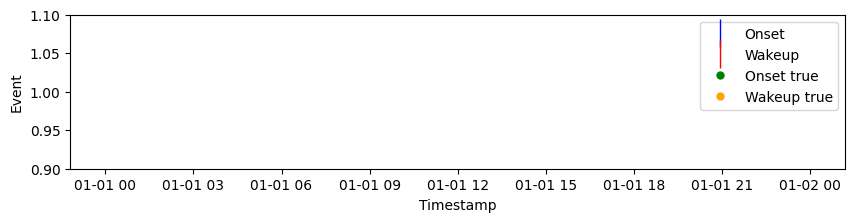

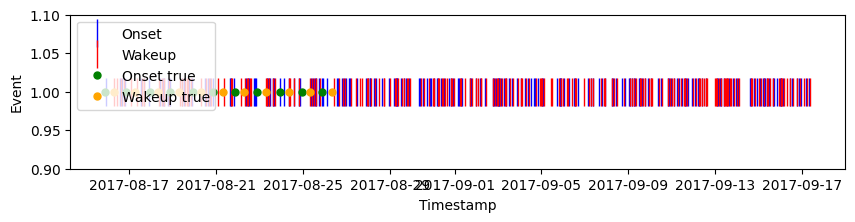

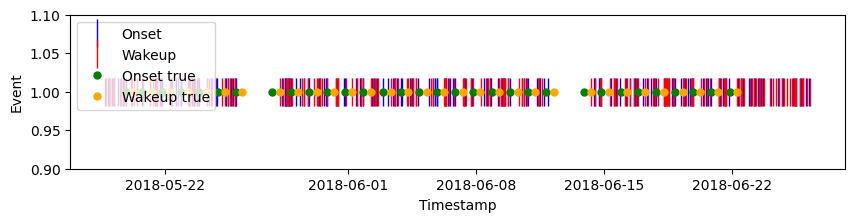

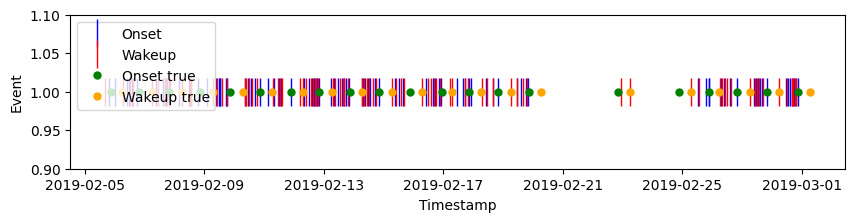

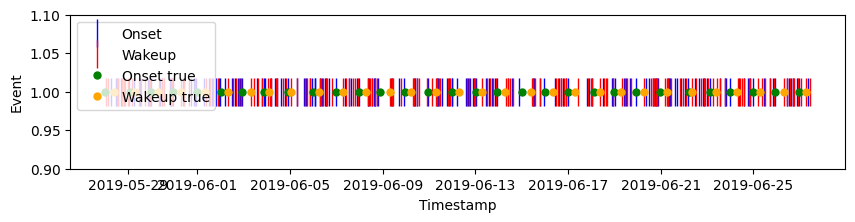

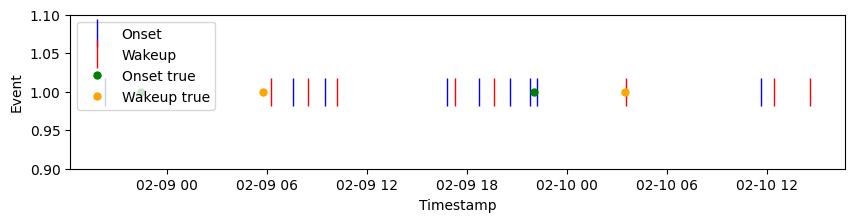

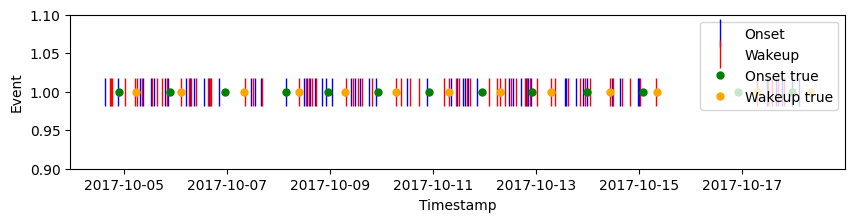

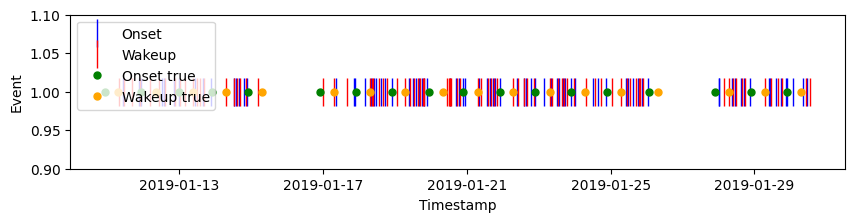

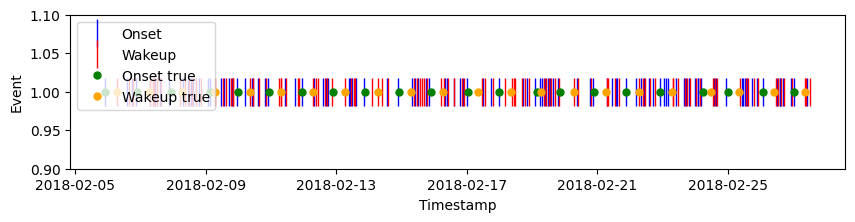

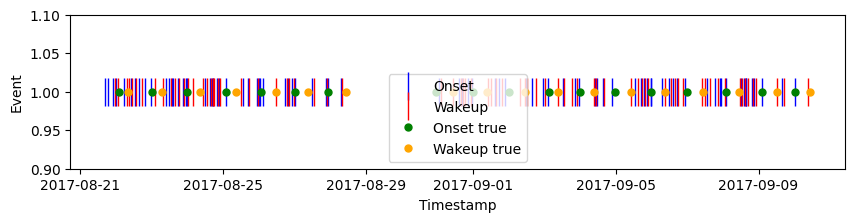

In [253]:
unique_series_ids = result['series_id'].unique().tolist()

for series_id in unique_series_ids:
    onset_events = result[(result['series_id'] == series_id) & (result['onset'] == 1)]
    wakeup_events = result[(result['series_id'] == series_id) & (result['wakeup'] == 1)]
    onset_events_true = test[(test['series_id'] == series_id) & (test['onset'] == 1)]
    wakeup_events_true = test[(test['series_id'] == series_id) & (test['wakeup'] == 1)]    
    
    plt.figure(figsize=(10, 2))
    plt.plot(onset_events['timestamp'], onset_events['onset'], '|', color='blue', markersize=20, label='Onset')
    plt.plot(wakeup_events['timestamp'], wakeup_events['wakeup'], '|', color='red', markersize=20, label='Wakeup')
    plt.plot(onset_events_true['timestamp'], onset_events_true['onset'], '.', color='green', markersize=10, label='Onset true')
    plt.plot(wakeup_events_true['timestamp'], wakeup_events_true['wakeup'], '.', color='orange', markersize=10, label='Wakeup true')

    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Event')
    plt.legend()
    plt.ylim([0.9, 1.1])
    plt.show()


## if the break between two sleeping window is smaller than 30 min count it as one

In [248]:
series = result.series_id.unique().tolist()
for serie in series:
    print(serie)
    onset_events = result[(result['series_id'] == serie) & (result['onset'] == 1)]
    wakeup_events = result[(result['series_id'] == serie) & (result['wakeup'] == 1)]
    
    for index, wakeup_row in wakeup_events.iterrows():
        print(result.loc[index].name)
        next_onset_rows = result.iloc[index:].loc[result['onset'] == 1]
        if not next_onset_rows.empty:
            next_onset_index = next_onset_rows.iloc[0].name
            print(next_onset_index)
            time_diff = (result.loc[next_onset_index]['timestamp'] - result.loc[index]['timestamp']).total_seconds() / 60
            print(time_diff)
            if time_diff < 30:
                print('delete')
                result.loc[index, 'wakeup'] = 0
                result.loc[next_onset_index, 'onset'] = 0
        else:
            print("No row found with 'onset' == 1 after index", index)


2fc653ca75c7
31011ade7c0a
35042
35043
1.0
delete
35045
35046
1.0
delete
35059
35060
1.0
delete
35095
35097
2.0
delete
35128
35129
1.0
delete
35152
35153
1.0
delete
35172
35173
1.0
delete
35185
35186
1.0
delete
35229
35230
1.0
delete
35256
35257
1.0
delete
35351
35352
1.0
delete
35389
35390
1.0
delete
35419
35420
1.0
delete
35444
35445
1.0
delete
35462
35463
1.0
delete
35472
35473
1.0
delete
35554
35555
1.0
delete
35577
35607
30.0
35608
35621
13.0
delete
35623
35663
40.0
35664
35683
19.0
delete
35684
35690
6.0
delete
35691
35774
83.0
35775
35798
23.0
delete
35792
35843
51.0
35799
35843
44.0
35844
35988
144.0
35989
36000
11.0
delete
36001
36019
18.0
delete
36020
36021
1.0
delete
36022
36035
13.0
delete
36036
36058
22.0
delete
36059
36074
15.0
delete
36075
36082
7.0
delete
36083
36086
3.0
delete
36087
36096
9.0
delete
36097
36103
6.0
delete
36104
36138
34.0
36139
36152
13.0
delete
36153
36168
15.0
delete
36169
36187
18.0
delete
36188
36200
12.0
delete
36201
36209
8.0
delete
36211
36216
5.

## if a sleeping period is shorter than 30 min delete it

In [252]:
series = result.series_id.unique().tolist()
for serie in series:
    print(serie)
    onset_events = result[(result['series_id'] == serie) & (result['onset'] == 1)]
    wakeup_events = result[(result['series_id'] == serie) & (result['wakeup'] == 1)]   
     
    for index, onset_row in onset_events.iterrows():
        #print(result.loc[index].name)
        next_wakeup_rows = result.iloc[index:].loc[result['wakeup'] == 1]
        if not next_wakeup_rows.empty:
            next_wakeup_index = next_wakeup_rows.iloc[0].name
            #print(next_onset_index)
            time_diff = (result.loc[next_wakeup_index]['timestamp'] - result.loc[index]['timestamp']).total_seconds() / 60
            print(time_diff)
            if time_diff < 30:
                print('delete')
                result.loc[index, 'onset'] = 0
                result.loc[next_wakeup_index, 'wakeup'] = 0
        else:
            print("No row found with 'onset' == 1 after index", index)

2fc653ca75c7
31011ade7c0a
499.0
16.0
delete
28.0
delete
18.0
delete
1.0
delete
116.0
139.0
393.0
22.0
delete
13.0
delete
21.0
delete
62.0
17.0
delete
43.0
19.0
delete
8.0
delete
1.0
delete
1.0
delete
665.0
86.0
1.0
delete
7.0
delete
54.0
41.0
25.0
delete
12.0
delete
20.0
delete
1.0
delete
71.0
661.0
12.0
delete
37.0
27.0
delete
35.0
1.0
delete
23.0
delete
34.0
82.0
1.0
delete
575.0
1.0
delete
20.0
delete
71.0
7.0
delete
1.0
delete
76.0
33.0
8.0
delete
1.0
delete
1.0
delete
365.0
27.0
delete
1.0
delete
1.0
delete
3.0
delete
1.0
delete
46.0
37.0
1.0
delete
518.0
1.0
delete
47.0
43.0
48.0
1.0
delete
1.0
delete
1.0
delete
813.0
739.0
668.0
49.0
54.0
108.0
27.0
delete
5.0
delete
34.0
45.0
9.0
delete
11.0
delete
29.0
delete
588.0
312.0
68.0
1.0
delete
1.0
delete
8.0
delete
1.0
delete
41.0
1.0
delete
5.0
delete
9.0
delete
42.0
645.0
38.0
22.0
delete
59.0
111.0
30.0
1.0
delete
74.0
22.0
delete
781.0
674.0
432.0
23.0
delete
6.0
delete
2.0
delete
111.0
58.0
15.0
delete
2.0
delete
1.0
delete
64.0

## only keep the longest sleeping window of one night

In [254]:
result.head()

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0,0,0,0
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0,0,0,0


### get a column night

In [255]:
series = result.series_id.unique().tolist()
for serie in series:
    lenght = len(result[(result['series_id'] == serie)])
    print(serie, lenght)
    counter = 1
    print(counter)
    result.loc[result['series_id'] == serie, 'night'] = 1
    next_index = 0
    print(next_index)
    
    # Check if there are any occurrences where series_id is '2fc653ca75c7' and hour is 15
    while (result[(result['series_id'] == serie) & (result.index > next_index + 60)]['timestamp'].dt.hour == 15).any():
        counter += 1
        print(counter)
        next_index = result.loc[(result['series_id'] == serie) & (result.index > next_index + 60)].loc[result['timestamp'].dt.hour == 15].index[0]
        print(next_index)
        result.loc[(result['series_id'] == serie) & (result.index >= next_index), 'night'] = counter
    
    print("No occurrences found that meet the conditions.")

    

2fc653ca75c7 34740
1
0
2
240
3
1680
4
3120
5
4560
6
6000
7
7440
8
8880
9
10320
10
11760
11
13200
12
14640
13
16080
14
17520
15
18960
16
20400
17
21840
18
23280
19
24720
20
26160
21
27600
22
29040
23
30480
24
31920
25
33360
No occurrences found that meet the conditions.
31011ade7c0a 47070
1
0
2
36075
3
37515
4
38955
5
40395
6
41835
7
43275
8
44715
9
46155
10
47595
11
49035
12
50475
13
51915
14
53355
15
54795
16
56235
17
57675
18
59115
19
60555
20
61995
21
63435
22
64875
23
66315
24
67755
25
69195
26
70635
27
72075
28
73515
29
74955
30
76395
31
77835
32
79275
33
80715
No occurrences found that meet the conditions.
3318a0e3ed6f 55980
1
0
2
81960
3
83400
4
84840
5
86280
6
87720
7
89160
8
90600
9
92040
10
93480
11
94920
12
96360
13
97800
14
99240
15
100680
16
102120
17
103560
18
105000
19
106440
20
107880
21
109320
22
110760
23
112200
24
113640
25
115080
26
116520
27
117960
28
119400
29
120840
30
122280
31
123720
32
125160
33
126600
34
128040
35
129480
36
130920
37
132360
38
133800
39
13524

In [256]:
result.head()

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0,1.0
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0,1.0
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0,1.0
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0,0,0,0,1.0
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0,0,0,0,1.0


### only keep one sleep window per night

In [257]:
series = result.series_id.unique().tolist()
#series = series[1:]
result['event'] = np.NAN
for serie in series:
    nights = result[result['series_id'] == serie]['night'].unique().tolist()
    for night in nights:
        print(serie, night)
        
        max_window_duration = pd.Timedelta(0)
        current_window_start = None
        current_window_end = None
        onset_index = None
        wakeup_index = None
        
        for index, row in result[(result['series_id'] == serie) & (result['night'] == night)].iterrows():
            if row['onset'] == 1:
                # Start of a potential sleeping window
                current_window_start = row['timestamp']
                print(current_window_start)
                onset_index = index
                print(onset_index)
            elif row['wakeup'] == 1 and current_window_start is not None:
                # End of a potential sleeping window
                current_window_end = row['timestamp']
                wakeup_index = index
                window_duration = current_window_end - current_window_start
                print(window_duration)
                if window_duration > max_window_duration:
                    max_window_duration = window_duration
                    max_onset_index = onset_index
                    max_wakeup_index = wakeup_index

# 'max_window_duration' will contain the duration of the longest sleeping window
# 'max_onset_index' will contain the index of the onset event for the longest window
# 'max_wakeup_index' will contain the index of the wakeup event for the longest window

        print(f"The longest sleeping window duration is: {max_window_duration}")
        print(f"Starts at index: {max_onset_index}, Ends at index: {max_wakeup_index}")
        # Check if the longest window duration is longer than 30 minutes
        if max_window_duration > pd.Timedelta(minutes=30):
            # Assign 'onset' and 'wakeup' events based on indexes
            result.loc[max_onset_index, 'event'] = 'onset'
            result.loc[max_wakeup_index, 'event'] = 'wakeup'
            
        

2fc653ca75c7 1.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 2.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 3.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 4.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 5.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 6.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 7.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 8.0
The longest sleeping window duration is: 0 days 00:00:00
Starts at index: 343601, Ends at index: 344212
2fc653ca75c7 9.0
The longest sle

/var/folders/40/3xwnc19j5wddty6wnqjyxg1h0000gn/T/ipykernel_14004/2352021295.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'onset' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[max_onset_index, 'event'] = 'onset'


The longest sleeping window duration is: 0 days 11:01:00
Starts at index: 39327, Ends at index: 39988
31011ade7c0a 5.0
2017-08-19 16:34:00
40489
0 days 00:34:00
2017-08-19 18:36:00
40611
0 days 01:22:00
2017-08-19 21:21:00
40776
0 days 09:35:00
2017-08-20 11:40:00
41635
0 days 01:11:00
2017-08-20 14:53:00
41828
The longest sleeping window duration is: 0 days 09:35:00
Starts at index: 40776, Ends at index: 41351
31011ade7c0a 6.0
2017-08-20 17:28:00
41983
0 days 00:33:00
2017-08-20 20:33:00
42168
0 days 06:05:00
0 days 12:16:00
The longest sleeping window duration is: 0 days 12:16:00
Starts at index: 42168, Ends at index: 42904
31011ade7c0a 7.0
2017-08-21 15:41:00
43316
0 days 00:46:00
2017-08-21 17:03:00
43398
0 days 00:37:00
2017-08-21 19:25:00
43540
0 days 08:38:00
0 days 12:26:00
2017-08-22 09:18:00
44373
0 days 00:47:00
2017-08-22 11:02:00
44477
0 days 00:43:00
2017-08-22 12:34:00
44569
0 days 00:48:00
0 days 02:22:00
The longest sleeping window duration is: 0 days 12:26:00
Starts a

In [258]:
result[result['event'].notna()]

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night,event
35078,2017-08-15 22:23:00,31011ade7c0a,4056,0.0,1.0,1,0,1,1.0,onset
35799,2017-08-16 10:24:00,31011ade7c0a,12708,1.0,1.0,1,1,0,1.0,wakeup
36326,2017-08-16 19:11:00,31011ade7c0a,19032,0.0,1.0,1,0,1,2.0,onset
37106,2017-08-17 08:11:00,31011ade7c0a,28392,1.0,1.0,1,1,0,2.0,wakeup
37951,2017-08-17 22:16:00,31011ade7c0a,38532,0.0,1.0,1,0,1,3.0,onset
...,...,...,...,...,...,...,...,...,...,...
342699,2017-09-08 11:24:00,3665c86afaf5,307008,1.0,1.0,1,1,0,18.0,wakeup
343597,2017-09-09 02:22:00,3665c86afaf5,317784,0.0,1.0,1,0,1,19.0,onset
344212,2017-09-09 12:37:00,3665c86afaf5,325164,1.0,1.0,1,1,0,19.0,wakeup
344934,2017-09-10 00:39:00,3665c86afaf5,333828,0.0,1.0,1,0,1,20.0,onset


## Check with true lables

In [259]:
true = pd.read_csv('../data/train_events.csv')

true['timestamp'] = true['timestamp'].astype(str)

true['timestamp'] = true['timestamp'].str.replace('T', ' ')

true['timestamp'] = true['timestamp'].str[:-5]

true['timestamp'] = pd.to_datetime(true['timestamp'])
true.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00


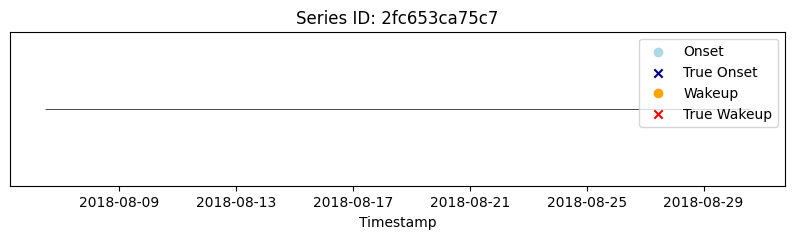

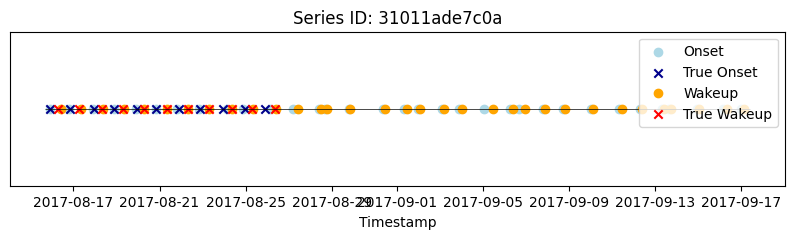

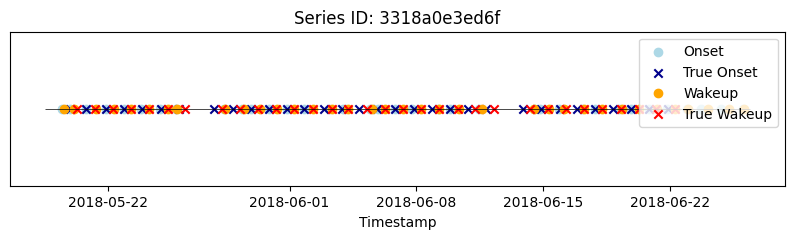

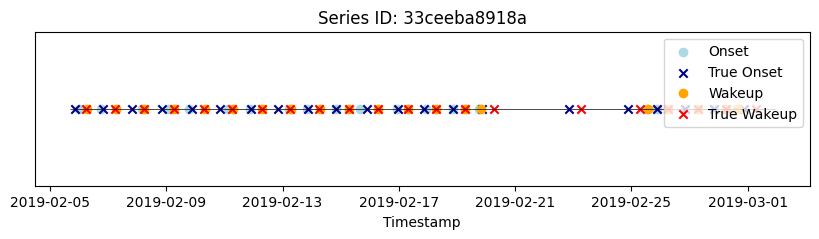

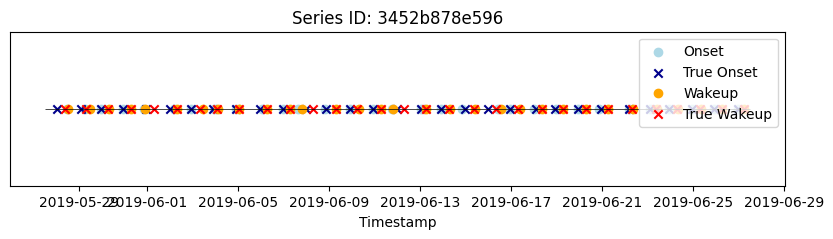

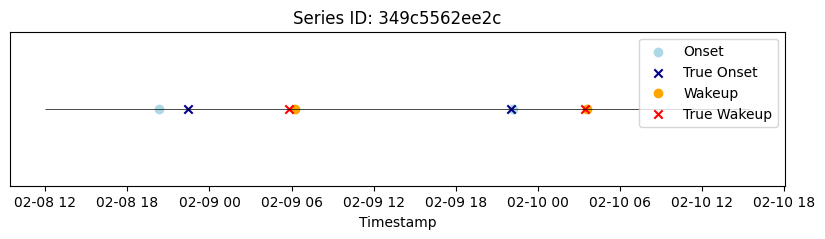

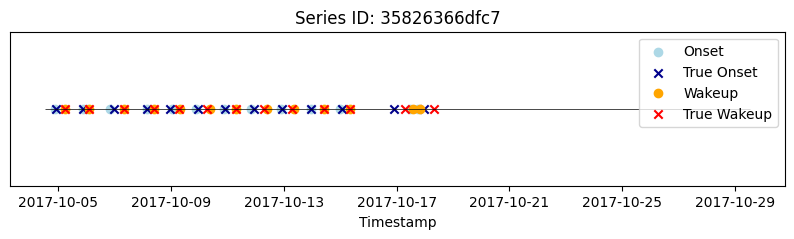

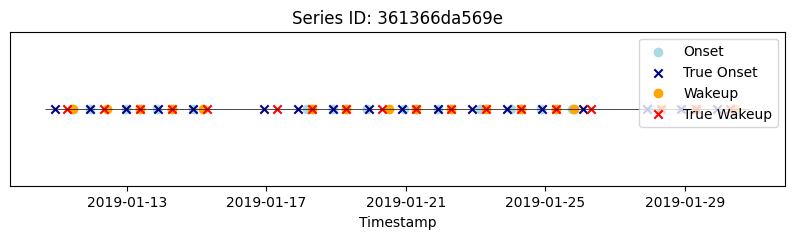

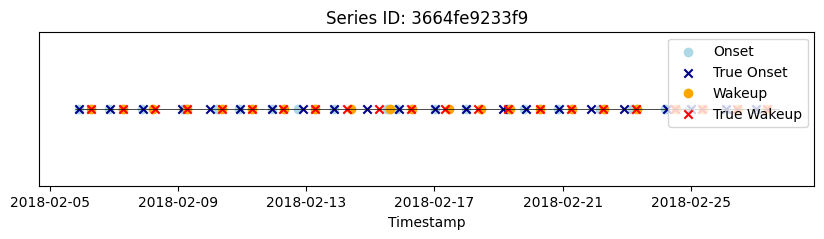

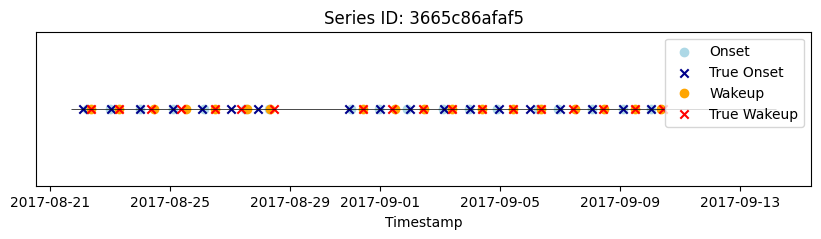

In [262]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Group the DataFrame by 'series_id'
grouped = result.groupby('series_id')
grouped2 = true.groupby('series_id')

# Iterate through each group (series_id)
for name, group in grouped:
    group2 = grouped2.get_group(name)
    # Create a new figure for each series_id
    plt.figure(figsize=(10, 2))

    # Create a horizontal line representing the timeline
    plt.hlines(y=0, color='black', linewidth=0.5, xmin=group['timestamp'].min(), xmax=group['timestamp'].max())

    # Plot the 'timestamp' with color-coded points for 'onset' and 'wakeup'
    plt.scatter(group[group['event'] == 'onset']['timestamp'], [0] * len(group[group['event'] == 'onset']), color='lightblue', marker = 'o', label='Onset')
    plt.scatter(group2[group2['event'] == 'onset']['timestamp'], [0] * len(group2[group2['event'] == 'onset']), color='darkblue', marker='x', label='True Onset')
    plt.scatter(group[group['event'] == 'wakeup']['timestamp'], [0] * len(group[group['event'] == 'wakeup']), color='orange', marker = 'o', label='Wakeup')
    plt.scatter(group2[group2['event'] == 'wakeup']['timestamp'], [0] * len(group2[group2['event'] == 'wakeup']), color='red', marker='x', label='True Wakeup')

    # Set labels and title
    plt.xlabel('Timestamp')
    plt.title(f'Series ID: {name}')

    # Remove y-axis ticks and labels
    plt.yticks([])

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


## add a curve around the window with percentage

In [263]:
result.head()

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night,event
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0,1.0,NaN
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0,1.0,NaN
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0,1.0,NaN
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0,0,0,0,1.0,NaN
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0,0,0,0,1.0,NaN


In [264]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission.head()

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0


In [265]:

# Define a function to calculate the score
def calculate_score(row):
    if row['event'] == 'onset' or row['event'] == 'wakeup':
        return 1
    else:
        return None

# Apply the function to create the 'score' column
result['score'] = result.apply(calculate_score, axis=1)

result.head()


,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night,event,score
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0,1.0,NaN,NaN
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0,1.0,NaN,NaN
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0,1.0,NaN,NaN
3,2018-08-06 11:03:00,2fc653ca75c7,36,3.0,0.0,0,0,0,1.0,NaN,NaN
4,2018-08-06 11:04:00,2fc653ca75c7,48,3.0,0.0,0,0,0,1.0,NaN,NaN


In [266]:
result[result['event'].notna()]

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night,event,score
35078,2017-08-15 22:23:00,31011ade7c0a,4056,0.0,1.0,1,0,1,1.0,onset,1.0
35799,2017-08-16 10:24:00,31011ade7c0a,12708,1.0,1.0,1,1,0,1.0,wakeup,1.0
36326,2017-08-16 19:11:00,31011ade7c0a,19032,0.0,1.0,1,0,1,2.0,onset,1.0
37106,2017-08-17 08:11:00,31011ade7c0a,28392,1.0,1.0,1,1,0,2.0,wakeup,1.0
37951,2017-08-17 22:16:00,31011ade7c0a,38532,0.0,1.0,1,0,1,3.0,onset,1.0
...,...,...,...,...,...,...,...,...,...,...,...
342699,2017-09-08 11:24:00,3665c86afaf5,307008,1.0,1.0,1,1,0,18.0,wakeup,1.0
343597,2017-09-09 02:22:00,3665c86afaf5,317784,0.0,1.0,1,0,1,19.0,onset,1.0
344212,2017-09-09 12:37:00,3665c86afaf5,325164,1.0,1.0,1,1,0,19.0,wakeup,1.0
344934,2017-09-10 00:39:00,3665c86afaf5,333828,0.0,1.0,1,0,1,20.0,onset,1.0


In [267]:
new = result.copy()

In [268]:
for index, row in new.iterrows():
    if row['score'] == 1:
        score_value = 1.0
        event_value = row['event']
        for i in range(index, -1, -1):
            new.at[i, 'score'] = score_value
            new.at[i, 'event'] = event_value
            score_value -= 0.1
            if score_value < 0:
                break

In [269]:
# Assuming 'df' is your DataFrame

# Iterate through the rows
for index, row in new.iterrows():
    if row['score'] == 1:
        score_value = 1.0
        event_value = row['event']
        for i in range(index, len(df)):
            new.at[i, 'score'] = score_value
            new.at[i, 'event'] = event_value
            score_value -= 0.1
            if score_value < 0:
                break

# Now, 'df' has been updated with the desired values in the other direction


In [270]:
new['score'] = new['score'].map('{:.1f}'.format)

row_id	series_id	step	event	score

In [272]:
new.head(3)

,timestamp,series_id,step,awake,wearable_on,awake_changes,wakeup,onset,night,event,score
0,2018-08-06 11:00:00,2fc653ca75c7,0,3.0,0.0,1,0,0,1.0,NaN,nan
1,2018-08-06 11:01:00,2fc653ca75c7,12,3.0,0.0,0,0,0,1.0,NaN,nan
2,2018-08-06 11:02:00,2fc653ca75c7,24,3.0,0.0,0,0,0,1.0,NaN,nan


In [273]:
submission = new.copy()
submission.drop(['timestamp', 'awake', 'wearable_on', 'awake_changes', 'wakeup', 'onset', 'night'], axis = 1, inplace=True)
submission.head(3)

,series_id,step,event,score
0,2fc653ca75c7,0,NaN,nan
1,2fc653ca75c7,12,NaN,nan
2,2fc653ca75c7,24,NaN,nan


In [274]:
submission = submission.dropna(subset=['event'])
submission.head()

,series_id,step,event,score
35068,31011ade7c0a,3936,onset,0.0
35069,31011ade7c0a,3948,onset,0.1
35070,31011ade7c0a,3960,onset,0.2
35071,31011ade7c0a,3972,onset,0.3
35072,31011ade7c0a,3984,onset,0.4


In [276]:
submission.reset_index(drop=True, inplace=True)
submission['row_id'] = submission.reset_index().index
submission.head()

,series_id,step,event,score,row_id
0,31011ade7c0a,3936,onset,0.0,0
1,31011ade7c0a,3948,onset,0.1,1
2,31011ade7c0a,3960,onset,0.2,2
3,31011ade7c0a,3972,onset,0.3,3
4,31011ade7c0a,3984,onset,0.4,4
